# Voter separation


In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bidi.algorithm import get_display
from importlib import reload
import sys

sys.path.append("..")
from src import vote_utils as vu
from src import dissimilarity_analysis as da

vu = reload(vu)
da = reload(da)
%matplotlib inline

  0%|          | 0/1216 [00:00<?, ?it/s]

dict_keys(['df_data_boxes', 'df_data', 'fig'])

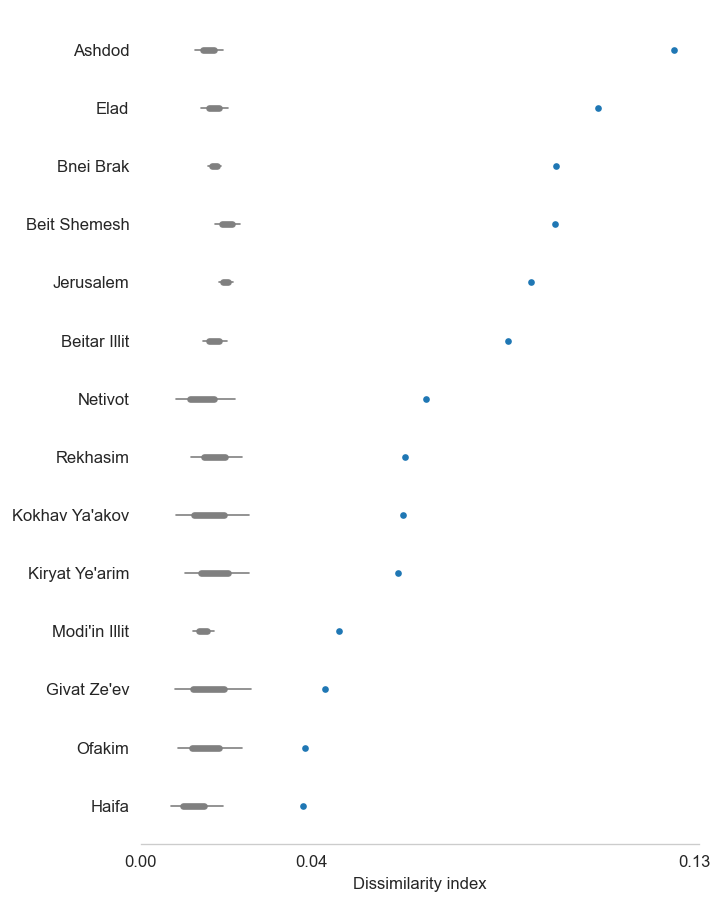

In [2]:
dct = da.main(knesset_numbers=25)
df_data = dct["df_data"]
dct.keys()

In [3]:
column_rename_dict = {
    "knesset_number": "Knesset Number",
    "city_code": "City Code",
    "city_name": "City Name",
    "n_boxes": "Number of Voting Boxes",
    "n_voters": "Number of Voters",
    "n_legal": "Number of Legal Voters",
    "n_relevant_boxes": "Number of Haredi Voting Boxes",
    "n_relevant_voters": "Number of Haredi Voters",
    "n_relevant_legal": "Number of Haredi Legal Votes",
    "city_ref_ratio": "City Reference Ratio",
    "city_ratios": "City Ratios",
    "dissimilarity": "Dissimilarity Index",
    "dissimilarity_simulation": "Dissimilarity Simulation",
    "simulation_fraction": "Simulation Fraction",
    "n_haredi_population": "Haredi Population",
    "fraction_haredim": "Fraction of Haredim Within the City Population",
    "fraction_haredim_of_jewish_population": "Fraction of Haredim in Jewish Population",
    "fraction_of_total_haredim_in_israel": "Fraction of Total Haredim in Israel",
   "ratio_haredi_to_total_boxes": "Ratio of Haredi-Total Voting Boxes",
    "ratio_haredi_to_total_voters": "Ratio of Haredi-Total Voters",
     "ratio_haredi_to_total_legal": "Ratio of Haredi-Total Legal Votes",
    
}

In [4]:
df_display = df_data[
    [
        "city_name",
        "dissimilarity",
        "n_boxes",
        "n_legal",
        "n_haredi_population",
        "fraction_haredim",
        "n_relevant_boxes",
        "n_relevant_legal",
    ]
].sort_values("dissimilarity", ascending=False).rename(
    columns=column_rename_dict
).round(
    3
)
df_display.to_clipboard()
df_display

,City Name,Dissimilarity Index,Number of Voting Boxes,Number of Legal Voters,Haredi Population,Fraction of Haredim Within the City Population,Number of Haredi Voting Boxes,Number of Haredi Legal Votes
0,Ashdod,0.125,302,116294,48626,0.214,30,15277
1,Elad,0.107,39,19637,46058,0.931,36,18231
2,Bnei Brak,0.097,187,87692,202959,0.929,170,80933
3,Beit Shemesh,0.097,133,51275,115398,0.746,63,23530
4,Jerusalem,0.092,706,264700,290090,0.295,202,79019
5,Beitar Illit,0.086,49,23688,63606,0.994,49,23688
6,Netivot,0.067,51,21185,20532,0.443,6,3221
7,Rekhasim,0.062,12,5837,13295,0.936,12,5837
8,Kokhav Ya'akov,0.062,9,4016,6708,0.685,5,2391
9,Kiryat Ye'arim,0.060,7,2703,6390,0.975,7,2703


In [5]:
np.percentile(df_data.city_ref_ratio, [0.25, 0.5, 0.75])  # shas / aguad

array([0.10262672, 0.10775852, 0.11289031])

In [6]:
summary = {
    'total haredi population': f'{df_data.n_haredi_population.sum():,d}',
    'total_voters': f'{df_data.n_voters.sum():,d}',
    'total legal votes': f'{df_data.n_legal.sum():,d}',
    'total boxes': f'{df_data.n_boxes.sum():,d}',
    'shas / utj voters': np.percentile(df_data.city_ref_ratio, [0.05, 0.5, 0.95]).round(3)  # shas / aguad
    
}
summary

{'total haredi population': '936,602',
 'total_voters': '1,226,667',
 'total legal votes': '789,393',
 'total boxes': '2,034',
 'shas / utj voters': array([0.099, 0.108, 0.117])}

## Factor analysis

### Regression analysis

In [7]:
cols = [
    "knesset_number",
    "city_code",
    "city_name",
    "n_boxes",
    "n_voters",
    "n_legal",
    "n_relevant_boxes",
    "n_relevant_voters",
    "n_relevant_legal",
    "dissimilarity",
    "n_haredi_population",
    # "fraction_haredim_of_jewish_population",
]
df_analysis = df_data[cols].copy().set_index(["knesset_number", "city_code"])
cols_relevant = [c for c in df_analysis.columns if "n_relevant" in c]
for col in cols_relevant:
    col_ref = col.replace("n_relevant", "n")
    col_ratio = col.replace("n_relevant", "ratio_haredi_to_total")
    df_analysis[col_ratio] = df_analysis[col] / df_analysis[col_ref]


df_analysis.head()

city_name  n_boxes  n_voters  n_legal  \
knesset_number city_code                                             
25             70               Ashdod      302    181784   116294   
               1309               Elad       39     23395    19637   
               6100          Bnei Brak      187    115586    87692   
               2610       Beit Shemesh      133     78064    51275   
               3000          Jerusalem      706    432125   264700   

                          n_relevant_boxes  n_relevant_voters  \
knesset_number city_code                                        
25             70                       30              18030   
               1309                     36              21709   
               6100                    170             105609   
               2610                     63              37283   
               3000                    202             123662   

                          n_relevant_legal  dissimilarity  \
knesset_number city_code                                    
25             70                    15277       0.125230   
               1309                  18231       0.107391   
               6100                  80933       0.097446   
               2610                  23530       0.097357   
               3000                  79019       0.091785   

                          n_haredi_population  ratio_haredi_to_total_boxes  \
knesset_number city_code                                                     
25             70                       48626                     0.099338   
               1309                     46058                     0.923077   
               6100                    202959                     0.909091   
               2610                    115398                     0.473684   
               3000                    290090                     0.286119   

                          ratio_haredi_to_total_voters  \
knesset_number city_code                                 
25             70                             0.099184   
               1309                           0.927933   
               6100                           0.913683   
               2610                           0.477595   
               3000                           0.286172   

                          ratio_haredi_to_total_legal  
knesset_number city_code                               
25             70                            0.131365  
               1309                          0.928400  
               6100                          0.922923  
               2610                          0.458898  
               3000                          0.298523

In [8]:
col_city = "city_name"
col_dissimilarity = "dissimilarity"
cols_rest = [c for c in df_analysis.columns if c not in [col_city, col_dissimilarity]]
#  move 'n_haredi_population' to the end
cols_rest.remove("n_haredi_population")
cols_rest.append("n_haredi_population")
cols_rest.remove('ratio_haredi_to_total_voters')
n_cols = 3
n_rows = int(np.ceil(len(cols_rest) / n_cols))
w = 3

In [9]:
# use statsmodels to perform a linear regression
import statsmodels.api as sm
print('Regression analysis is not a valid method for this data due to the high correlation between the variables')
# 
# y = df_analysis[col_dissimilarity]
# X = df_analysis[cols_rest].copy()
# cols_log = [c for c in cols_rest if c.startswith("n_")]
# for col in cols_log:
#     X[col] = np.log10(X[col])
# X = sm.add_constant(X)
# X = X.rename(columns={k: v for k, v in column_rename_dict.items() if k in df_analysis.columns})
# # For small sample sizes
# # HC3 is often recommended because it
# # is more robust to influential outliers.
# model = sm.OLS(y, X).fit(cov_type="HC3")
# model.summary()

Regression analysis is not a valid method for this data due to the high correlation between the variables


In [10]:
# # get the cefficient table
# df_coefficients = pd.DataFrame({
#     "coef": model.params,
#     "std_err": model.bse,
#     "t": model.tvalues,
#     "p": model.pvalues,
#     "p_corrected": model.pvalues,
#     'abs_coef': np.abs(model.params),
# }).sort_values('abs_coef', ascending=False)
# df_coefficients

### Spearman correlation

In [11]:
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

rho_values = []
p_values = []

for col in cols_rest:
    x = df_analysis[col]
    if col.startswith("n_"):
        x = np.log10(x)
    rho, p = spearmanr(x, df_analysis[col_dissimilarity])
    rho_values.append(rho)
    p_values.append(p)
rho_values = np.array(rho_values)
p_values = np.array(p_values)
# Perform Benjamini-Yekutieli correction
alpha = 0.05
reject, p_values_corrected, _, _ = multipletests(p_values, alpha=alpha, method="fdr_bh")
df_corr = pd.DataFrame(
    {
        "rho": rho_values,
        "p": p_values,
        "p_corrected": p_values_corrected,
        "reject": reject,
    },
    index=cols_rest,
).sort_values("p_corrected")
df_corr_display = df_corr.copy()
df_corr_display.index = [column_rename_dict.get(c, c) for c in df_corr.index]
df_corr_display.round(3)

,rho,p,p_corrected,reject
Number of Haredi Voting Boxes,0.678,0.008,0.028,True
Number of Haredi Voters,0.666,0.009,0.028,True
Number of Haredi Legal Votes,0.666,0.009,0.028,True
Haredi Population,0.600,0.023,0.052,False
Number of Voting Boxes,0.288,0.318,0.409,False
Number of Voters,0.292,0.311,0.409,False
Number of Legal Voters,0.341,0.233,0.409,False
Ratio of Haredi-Total Voting Boxes,0.107,0.717,0.717,False
Ratio of Haredi-Total Legal Votes,0.107,0.717,0.717,False


In [12]:
df_corr_display.index

Index(['Number of Haredi Voting Boxes', 'Number of Haredi Voters',
       'Number of Haredi Legal Votes', 'Haredi Population',
       'Number of Voting Boxes', 'Number of Voters', 'Number of Legal Voters',
       'Ratio of Haredi-Total Voting Boxes',
       'Ratio of Haredi-Total Legal Votes'],
      dtype='object')

In [13]:
def set_ticks_and_labels(ax, which, values, log_transform=False):
    min_val = values.min()
    max_val = values.max()
    mid_point = (min_val + max_val) / 2
    tks = [min_val, mid_point, max_val]
    if log_transform:
        labels = [f"{int(np.round(np.power(10, t), -2)):,d}" for t in tks]
    else:
        labels = [f"{t:.2f}" for t in tks]
    if which == "x":
        ax.set_xticks(tks)
        ax.set_xticklabels(labels)
    elif which == "y":
        ax.set_yticks(tks)
        ax.set_yticklabels(labels)
    return ax
    
    
    
def my_regplot(data, x_col, y_col, ax=None, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    x = data[x_col]
    if x_col.startswith("n_"):
        log_transform = True
        x = np.log10(x)
    else:
        log_transform = False
    y = data[y_col]
    sns.regplot(x=x, y=y, data=data, ax=ax, color=color)
    ax.set_xlabel('')
    ax.set_ylabel('')
    sns.despine(ax=ax)
    ax.grid(False)
    set_ticks_and_labels(ax, "x", x, log_transform=log_transform)
    set_ticks_and_labels(ax, "y", y)
    
    return ax

In [14]:
cols_rest

['n_boxes',
 'n_voters',
 'n_legal',
 'n_relevant_boxes',
 'n_relevant_voters',
 'n_relevant_legal',
 'ratio_haredi_to_total_boxes',
 'ratio_haredi_to_total_legal',
 'n_haredi_population']

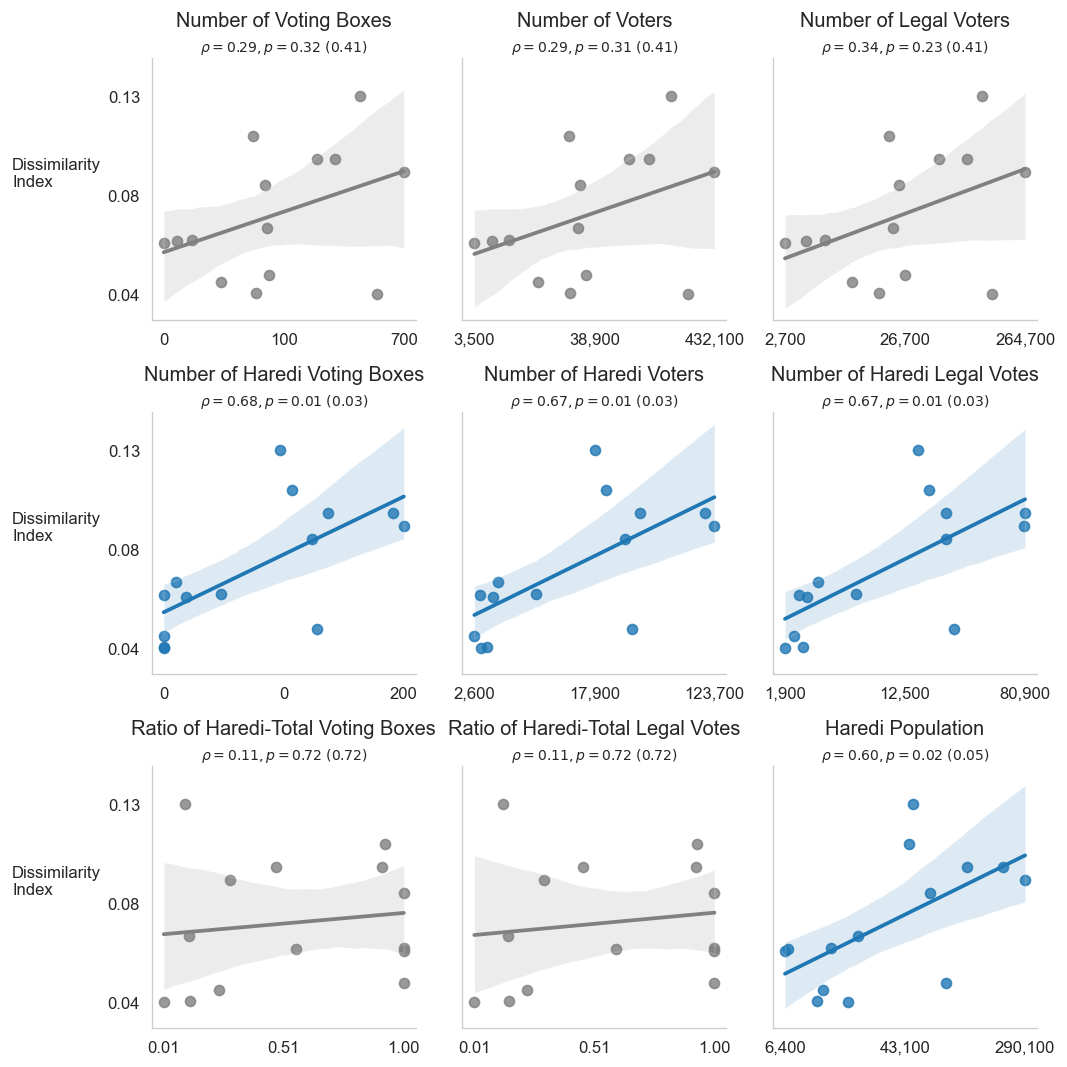

In [15]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * w, n_rows * w), sharey=True, dpi=120)
axes = axes.flatten()

for i, col in enumerate(cols_rest):
    ax = axes[i]
    
    rho = df_corr.loc[col, "rho"]
    p = df_corr.loc[col, "p"]
    p_corr = df_corr.loc[col, "p_corrected"]
    reject = df_corr.loc[col, "reject"]
    color = "C0" if p < 0.05 else "gray"
    
    my_regplot(df_analysis, col, col_dissimilarity, ax=ax, color=color)
    col_name = column_rename_dict.get(col, col)
    ttl = f"{col_name}\n$_{{ρ={rho:.2f}, p={p:.2f} \\; ({p_corr:.2f})}}$"
    ax.set_title(ttl)
    
    # Set Y label only on leftmost axes
    if i % n_cols != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel("Dissimilarity\nIndex", rotation=0, ha="right", ma='left')

# Clean up any unused axes
for i in range(len(cols_rest), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
fig.tight_layout()

In [16]:
# fn_translations = os.path.join( "/Users/boris/devel/jce/segregation/data/external/israeli_cities_hebrew_english.csv")
# df_translations = pd.read_csv(fn_translations).set_index("city_name")

In [17]:
# fn_demographics = '/Users/boris/devel/jce/segregation/data/external/haredi_population_by_city.xlsx'
# df_demographics = pd.read_excel(fn_demographics, skiprows=4).rename(columns={'Unnamed: 1': 'city_name'}).drop(columns='Unnamed: 0').dropna().rename(columns= {
#     "אוכלוסייה חרדית ביישוב": "haredi_population",
#     "שיעור החרדים ביישוב": "fraction_haredim",
#     "שיעור החרדים מהאוכלוסייה היהודית ביישוב": "fraction_haredim_of_jewish_population",
#     "שיעור מכלל החרדים בישראל": "fraction_of_total_haredim_in_israel"
# })
# df_demographics.city_name = df_translations.loc[df_demographics.city_name, 'city_name_english'].values
#
# df_demographics